# Statistical downscaling of ERA5 2m air temperature over Germany using DeepSensor

This notebook demonstrates how to use DeepSensor to train a ConvNP model to perform statistical downscaling of ERA5 2m air temperature over Germany. The model ingests coarsened ERA5 temperature and auxiliary variables and is trained to predict fine-scale weather station temperature based on high resolution auxiliary variables (e.g. elevation and topographic position index).

In [15]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import logging
logging.captureWarnings(True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import deepsensor.torch
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.active_learning.algorithms import GreedyAlgorithm
from deepsensor.active_learning.acquisition_fns import Stddev

from deepsensor.train.train import train_epoch, set_gpu_default_device
from deepsensor.data.utils import construct_x1x2_ds

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import seaborn as sns

In [17]:
crs = ccrs.PlateCarree()

use_gpu = True
if use_gpu:
    set_gpu_default_device()

## Load raw data

In [18]:
# Load raw data
era5_raw_ds = xr.open_mfdataset('../../germany/era5/*.nc')
era5_raw_ds = era5_raw_ds["t2m"]
era5_raw_ds = era5_raw_ds - 273.15
# Coarsen to CMIP6-ish resolution
print(era5_raw_ds.shape)
era5_raw_ds = era5_raw_ds.coarsen(lat=5, lon=5, boundary="trim").mean()
era5_raw_ds = era5_raw_ds.load()
print(era5_raw_ds.shape)

(11626, 41, 45)
(11626, 8, 9)


<xarray.DataArray 't2m' (time: 11626, lat: 8, lon: 9)>
array([[[-1.74561405e+00, -6.42056274e+00, -1.09890480e+01, ...,
         -7.72960949e+00, -4.85178471e+00, -2.55698729e+00],
        [-2.44376087e+00, -3.07936525e+00, -3.27973270e+00, ...,
         -8.20817471e+00, -7.22765255e+00, -3.94840813e+00],
        [-1.75538456e+00, -2.15525031e+00, -2.36898804e+00, ...,
         -4.62086058e+00, -3.89983034e+00, -3.30233026e+00],
        ...,
        [-1.61606446e-01, -1.67722654e+00, -2.04676747e+00, ...,
         -1.73686278e+00, -1.61427736e+00, -1.69267583e+00],
        [ 1.71598756e+00,  4.90406483e-01, -5.17236352e-01, ...,
         -1.13118410e+00,  8.03710893e-03, -5.50780058e-01],
        [ 3.22462654e+00,  2.65523434e+00,  1.51160526e+00, ...,
          1.25215328e+00,  1.73223150e+00,  1.85804319e+00]],

       [[ 1.51220700e-02, -5.75024891e+00, -1.02970724e+01, ...,
         -7.83874130e+00, -4.81738663e+00, -2.41189694e+00],
        [-6.16070569e-01, -1.64555538e+00, -2.66

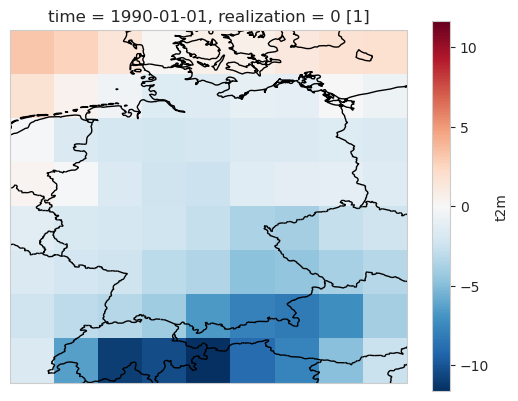

In [19]:
print(era5_raw_ds)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
era5_raw_ds.isel(time=0).plot()
ax.add_feature(cf.BORDERS)
ax.coastlines()

In [20]:
hires_aux_raw_ds = xr.open_mfdataset('../../germany/elevation/*.nc').rename({'LAT': 'lat', 'LON': 'lon'}).coarsen(lat=5, lon=5, boundary='trim').mean()
hires_aux_raw_ds = hires_aux_raw_ds
print(hires_aux_raw_ds)

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 2640)
Coordinates:
  * lat      (lat) float64 56.0 55.99 55.99 55.99 ... 47.02 47.01 47.01 47.0
  * lon      (lon) float64 5.002 5.006 5.01 5.014 ... 15.98 15.99 15.99 16.0
Data variables:
    HEIGHT   (lat, lon) float64 dask.array<chunksize=(2160, 2640), meta=np.ndarray>


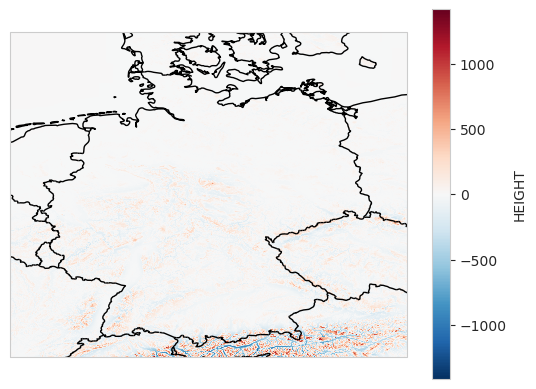

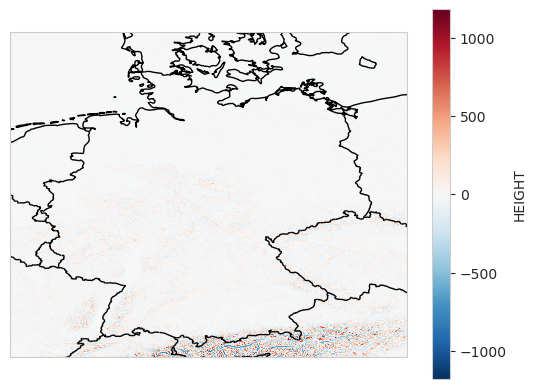

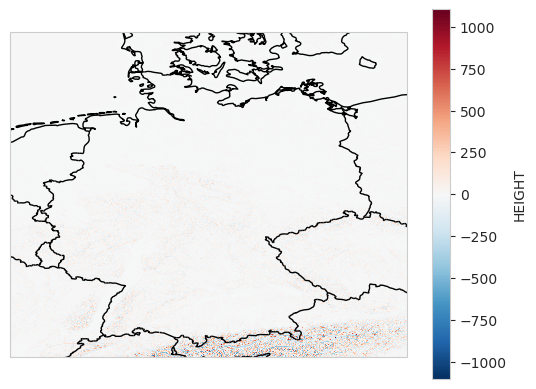

In [21]:
# Compute Topographic Position Index from elevation data
import scipy

# Resolutions in coordinate values along the spatial row and column dimensions
#   Here we assume the elevation is on a regular grid, so the first difference
#   is equal to all others.
coord_names = list(hires_aux_raw_ds.dims)
resolutions = np.array(
    [np.abs(np.diff(hires_aux_raw_ds.coords[coord].values)[0]) for coord in coord_names])

for window_size in [.1, .05, .025]:
    smoothed_elev_da = hires_aux_raw_ds['HEIGHT'].copy(deep=True)

    # Compute gaussian filter scale in terms of grid cells
    scales = window_size / resolutions

    smoothed_elev_da.data = scipy.ndimage.gaussian_filter(
        smoothed_elev_da.data, sigma=scales, mode='nearest')

    TPI_da = hires_aux_raw_ds['HEIGHT'] - smoothed_elev_da
    hires_aux_raw_ds[f"TPI_{window_size}"] = TPI_da

    fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
    TPI_da.plot(ax=ax)
    ax.add_feature(cf.BORDERS)
    ax.coastlines()

<xarray.Dataset>
Dimensions:    (lat: 2160, lon: 2640)
Coordinates:
  * lat        (lat) float64 56.0 55.99 55.99 55.99 ... 47.02 47.01 47.01 47.0
  * lon        (lon) float64 5.002 5.006 5.01 5.014 ... 15.98 15.99 15.99 16.0
Data variables:
    HEIGHT     (lat, lon) float64 dask.array<chunksize=(2160, 2640), meta=np.ndarray>
    TPI_0.1    (lat, lon) float64 dask.array<chunksize=(2160, 2640), meta=np.ndarray>
    TPI_0.05   (lat, lon) float64 dask.array<chunksize=(2160, 2640), meta=np.ndarray>
    TPI_0.025  (lat, lon) float64 dask.array<chunksize=(2160, 2640), meta=np.ndarray>


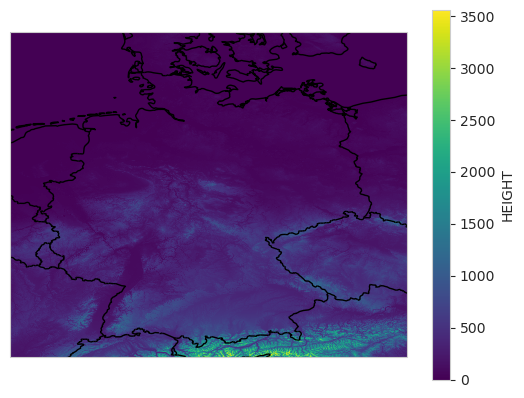

In [22]:
print(hires_aux_raw_ds)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
hires_aux_raw_ds['HEIGHT'].plot(ax=ax)
ax.add_feature(cf.BORDERS)
ax.coastlines()
fig.savefig("hires_elevation.png", bbox_inches="tight")

<xarray.DataArray 'HEIGHT' (lat: 108, lon: 132)>
dask.array<mean_agg-aggregate, shape=(108, 132), dtype=float64, chunksize=(108, 132), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 55.96 55.88 55.79 55.71 ... 47.29 47.21 47.13 47.04
  * lon      (lon) float64 5.041 5.125 5.208 5.291 ... 15.71 15.79 15.87 15.96
Attributes:
    transform:      [ 8.33333333e-04  0.00000000e+00  4.99958333e+00  0.00000...
    crs:            +init=epsg:4326
    res:            [0.00083333 0.00083333]
    is_tiled:       0
    nodatavals:     nan
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area


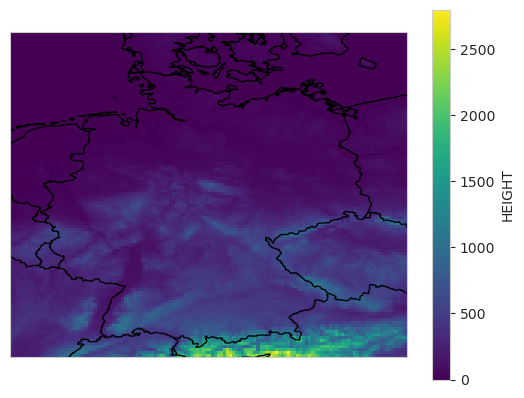

In [23]:
aux_raw_ds = hires_aux_raw_ds.coarsen(lat=20, lon=20, boundary='trim').mean()["HEIGHT"]
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
aux_raw_ds.plot(ax=ax)
ax.add_feature(cf.BORDERS)
ax.coastlines()
fig.savefig("lowres_elevation.png", bbox_inches="tight")
print(aux_raw_ds)

In [24]:
# Print resolution of lowres and hires elevation data
print(f"Lowres lat resolution: {np.abs(np.diff(aux_raw_ds.coords['lat'].values)[0]):.4f} degrees")
print(f"Lowres lon resolution: {np.abs(np.diff(aux_raw_ds.coords['lon'].values)[0]):.4f} degrees")
print(f"Hires lat resolution: {np.abs(np.diff(hires_aux_raw_ds.coords['lat'].values)[0]):.4f} degrees")
print(f"Hires lon resolution: {np.abs(np.diff(hires_aux_raw_ds.coords['lon'].values)[0]):.4f} degrees")

Lowres lat resolution: 0.0833 degrees
Lowres lon resolution: 0.0833 degrees
Hires lat resolution: 0.0042 degrees
Hires lon resolution: 0.0042 degrees


In [25]:
# Slice era5 data to elevation data's spatial extent
era5_raw_ds = era5_raw_ds.sel(lat=slice(aux_raw_ds["lat"].min(), aux_raw_ds["lat"].max()), lon=slice(aux_raw_ds["lon"].min(), aux_raw_ds["lon"].max()))

In [26]:
station_raw_df = pd.read_csv('../../germany/germany_station_data_daily.csv')
station_raw_df = station_raw_df.rename(columns={'TIME': 'time', 'LAT': 'lat', 'LON': 'lon'})
station_raw_df['time'] = pd.to_datetime(station_raw_df['time'])
station_raw_df

,lat,lon,time,T2M
0,47.3981,10.2757,2005-05-02,15.862500
1,47.3981,10.2757,2005-05-03,13.900000
2,47.3981,10.2757,2005-05-04,10.000000
3,47.3981,10.2757,2005-05-05,NaN
4,47.3981,10.2757,2005-05-06,NaN
...,...,...,...,...
3301196,55.0110,8.4125,2023-07-14,18.445833
3301197,55.0110,8.4125,2023-07-15,20.112500
3301198,55.0110,8.4125,2023-07-16,18.262500
3301199,55.0110,8.4125,2023-07-17,17.104167


In [27]:
print(station_raw_df.reset_index()['time'].min())
print(station_raw_df.reset_index()['time'].max())

2005-05-02 00:00:00
2023-07-18 00:00:00


In [28]:
# Compute daily mean temperature by resampling over 'TIME' and grouping by 'LAT'/'LON'
station_raw_df = station_raw_df.groupby(['lat', 'lon']).resample('D', on='time').mean()[['T2M']]
station_raw_df = station_raw_df.reset_index().set_index(['time', 'lat', 'lon']).sort_index()
station_raw_df

T2M
time       lat     lon               
2005-05-02 47.3981 10.2757  15.862500
           47.4210 10.9848   3.637500
           47.4830 11.0621  17.787500
           47.5627 7.7936   19.287500
           47.5776 9.7404   19.187500
...                               ...
2023-07-18 54.6410 10.0238  16.612500
           54.6791 13.4344  17.712500
           54.7903 8.9514   16.500000
           54.8273 9.5058   16.183333
           55.0110 8.4125   16.687500

[3301201 rows x 1 columns]

## Normalise/preprocess data

In [29]:
data_processor = DataProcessor(x1_name="lat", x1_map=(era5_raw_ds["lat"].min(), era5_raw_ds["lat"].max()), x2_name="lon", x2_map=(era5_raw_ds["lon"].min(), era5_raw_ds["lon"].max()))
era5_ds, station_df = data_processor([era5_raw_ds, station_raw_df])
aux_ds, hires_aux_ds = data_processor([aux_raw_ds, hires_aux_raw_ds], method="min_max")
print(data_processor)

DataProcessor with normalisation params:
{'HEIGHT': {'max': 2798.2248999999997, 'min': 0.0},
 'T2M': {'mean': 9.63523158748501, 'std': 7.379430792432267},
 'TPI_0.025': {'max': 1104.3115754206444, 'min': -926.2898691203725},
 'TPI_0.05': {'max': 1179.4161623897744, 'min': -1045.8118006587536},
 'TPI_0.1': {'max': 1414.6676017547015, 'min': -1149.0056097925672},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (47.75, 55.25), 'name': 'lat'},
            'x2': {'map': (5.5, 15.5), 'name': 'lon'}},
 't2m': {'mean': 9.396353721618652, 'std': 7.08495569229126}}


In [30]:
# Generate auxiliary dataset of x1/x2 coordinates to break translation equivariance in the model's CNN
# to enable learning non-stationarity
x1x2_ds = construct_x1x2_ds(aux_ds)
aux_ds['x1_arr'] = x1x2_ds['x1_arr']
aux_ds['x2_arr'] = x1x2_ds['x2_arr']
aux_ds

<xarray.DataArray 'HEIGHT' (x1: 108, x2: 132)>
array([[-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       ...,
       [-0.84337742, -0.8563277 , -0.85852274, ..., -0.65944267,
        -0.71958323, -0.74851006],
       [-0.84861102, -0.85596655, -0.86779454, ..., -0.7366622 ,
        -0.75219976, -0.75690281],
       [-0.85279503, -0.8672041 , -0.87023052, ..., -0.72920118,
        -0.74766774, -0.77249656]])
Coordinates:
  * x1       (x1) float64 1.094 1.083 1.072 1.061 ... -0.07217 -0.08328 -0.09439
  * x2       (x2) float64 -0.04588 -0.03754 -0.02921 ... 1.029 1.037 1.046
    x1_arr   (x1, x2) float64 1.094 1.094 1.094 ... -0.09439 -0.09439 -0.09439
    x2_arr   (x1, x2) float64 -0.04588 -0.03754 -0.02921 ... 1.029 1.037 1.046

## Set up TaskLoader

In [31]:
task_loader = TaskLoader(context=[era5_ds, aux_ds], target=station_df, aux_at_targets=hires_aux_ds)
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('t2m',), ('HEIGHT',))
Target variable IDs: (('T2M',),)
Auxiliary data at targets: ('HEIGHT', 'TPI_0.1', 'TPI_0.05', 'TPI_0.025')


## Set up ConvNP model

In [32]:
model = ConvNP(data_processor, task_loader, unet_channels=(64,)*4, points_per_unit=150, likelihood="gnp")

dim_yc inferred from TaskLoader: (1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 4
Setting aux_t_mlp_layers: (64, 64, 64)
encoder_scales inferred from TaskLoader: [0.0729166716337204, 0.00486111082136631]
decoder_scale inferred from TaskLoader: 0.006666666666666667


## Generate training tasks

In [33]:
import time
print("Loading Dask arrays...")
tic = time.time()
task_loader.load_dask()
print(f"Done in {time.time() - tic:.2f}s")

Loading Dask arrays...
Done in 0.98s


In [34]:
# Some dates are missing from the era5 data due to download fails
train_dates = era5_raw_ds.sel(time=slice("2006-01-01", "2017-12-15")).time.values
val_dates = era5_raw_ds.sel(time=slice("2018-01-01", "2018-12-15")).time.values

In [35]:
from tqdm import tqdm
train_tasks = []
for date in tqdm(train_dates[::2]):
    task = task_loader(date, context_sampling="all", target_sampling="all")
    train_tasks.append(task)

val_tasks = []
for date in tqdm(val_dates):
    task = task_loader(date, context_sampling="all", target_sampling="all")
    val_tasks.append(task)

100%|████████████████████████████████████████████████████████████████████████████████████████| 349/349 [00:09<00:00, 35.16it/s]


In [36]:
train_tasks[0]

time: Timestamp/2006-02-01 00:00:00
flag: NoneType/None
X_c: [('ndarray/float32/(1, 7)', 'ndarray/float32/(1, 9)'), ('ndarray/float32/(1, 108)', 'ndarray/float32/(1, 132)')]
Y_c: ['ndarray/float32/(1, 7, 9)', 'ndarray/float32/(1, 108, 132)']
X_t: ['ndarray/float32/(2, 430)']
Y_t: ['ndarray/float32/(1, 430)']
Y_t_aux: ndarray/float32/(4, 430)

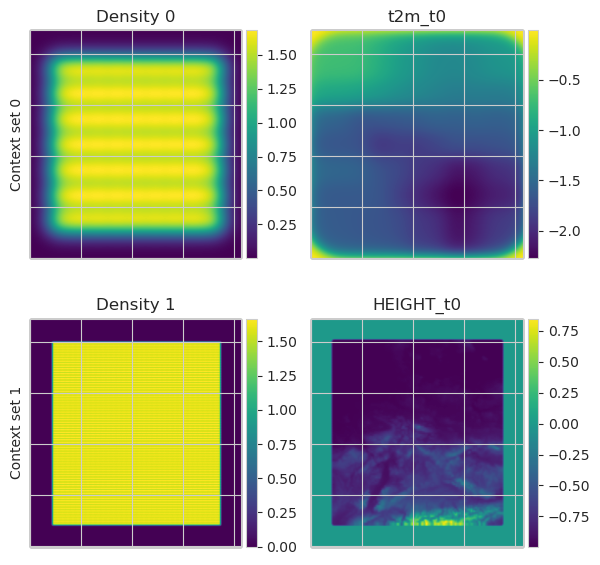

In [37]:
fig = deepsensor.plot.context_encoding(model, train_tasks[0], task_loader)

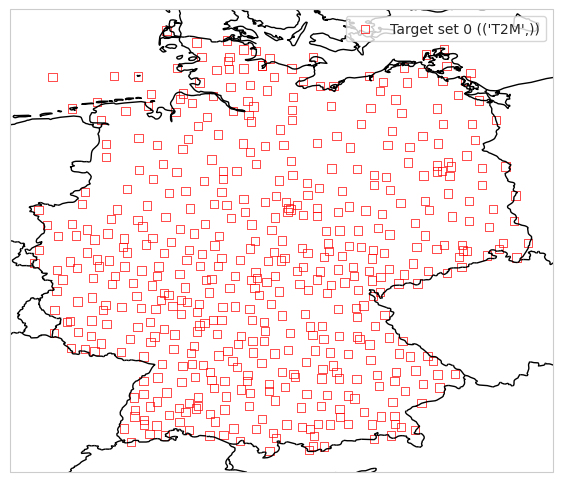

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw=dict(projection=crs))
ax.coastlines()
ax.add_feature(cf.BORDERS)
deepsensor.plot.offgrid_context(ax, task, data_processor, task_loader, plot_target=True, add_legend=True, linewidths=0.5)
plt.show()
fig.savefig("train_stations.png", bbox_inches="tight")

## Train model

In [39]:
import lab as B
def compute_val_loss(model, val_tasks):
    val_losses = []
    for task in val_tasks:
        val_losses.append(B.to_numpy(model.loss_fn(task, normalise=True)))
    return np.mean(val_losses)

In [ ]:
from tqdm import tqdm

n_epochs = 80
train_losses = []
val_losses = []

val_loss_best = np.inf

for epoch in tqdm(range(n_epochs)):
    batch_losses = train_epoch(model, train_tasks)
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)

    val_loss = compute_val_loss(model, val_tasks)
    val_losses.append(val_loss)

    if val_loss < val_loss_best:
        import torch
        import os
        val_loss_best = val_loss
        folder = "models/downscaling/"
        if not os.path.exists(folder): os.makedirs(folder)
        torch.save(model.model.state_dict(), folder + f"model.pt")

    # print(f"Epoch {epoch} train_loss: {train_loss:.2f}, val_loss: {val_loss:.2f}")

 20%|█████████████████▍                                                                     | 16/80 [37:15<2:29:06, 139.79s/it]

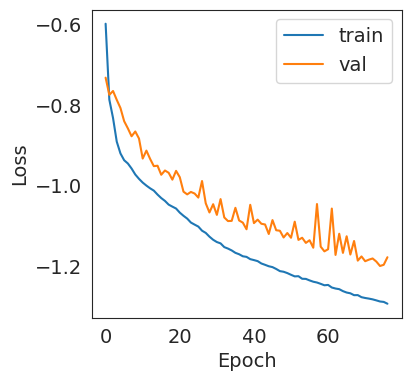

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(train_losses, label="train")
ax.plot(val_losses, label="val")
ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("loss.png", bbox_inches="tight")

### Load best model

In [44]:
# Load best model
import torch
folder = "models/downscaling/"
model.model.load_state_dict(torch.load(folder + f"model.pt"))

<All keys matched successfully>

## Perform inference on unseen data

### Targets on a grid: Predict directly to xarray

In [45]:
fontsize = 14

params = {
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'font.size': fontsize,
    'figure.titlesize': fontsize,
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'font.family': 'sans-serif',
    'figure.facecolor': 'w',
}

import matplotlib as mpl
mpl.rcParams.update(params)

In [92]:
def gen_test_fig(era5_raw_ds=None, mean_ds=None, std_ds=None, samples_ds=None, add_colorbar=False, var_clim=None, std_clim=None, var_cbar_label=None, std_cbar_label=None, fontsize=None, figsize=(15, 5)):
    if var_clim is None:
        vmin = np.array(min(era5_raw_ds.min(), mean_ds.min()))
        vmax = np.array(max(era5_raw_ds.max(), mean_ds.max()))
    else:
        vmin, vmax = var_clim

    if std_clim is None and std_ds is not None:
        std_vmin = np.array(std_ds.min())
        std_vmax = np.array(std_ds.max())
    elif std_clim is not None:
        std_vmin, std_vmax = std_clim
    else:
        std_vmin = None
        std_vmax = None

    ncols = 0
    if era5_raw_ds is not None:
        ncols += 1
    if mean_ds is not None:
        ncols += 1
    if std_ds is not None:
        ncols += 1
    if samples_ds is not None:
        ncols += samples_ds.shape[0]

    fig, axes = plt.subplots(1, ncols, subplot_kw=dict(projection=crs), figsize=figsize)

    axis_i = 0
    if era5_raw_ds is not None:
        ax = axes[axis_i]
        # era5_raw_ds.sel(lat=slice(mean_ds["lat"].min(), mean_ds["lat"].max()), lon=slice(mean_ds["lon"].min(), mean_ds["lon"].max())).plot(ax=ax, cmap="jet", vmin=vmin, vmax=vmax, add_colorbar=False)
        era5_raw_ds.plot(ax=ax, cmap="jet", vmin=vmin, vmax=vmax, add_colorbar=add_colorbar, cbar_kwargs=dict(label=var_cbar_label))
        ax.set_title("ERA5", fontsize=fontsize)

    if mean_ds is not None:
        axis_i += 1
        ax = axes[axis_i]
        mean_ds.plot(ax=ax, cmap="jet", vmin=vmin, vmax=vmax, add_colorbar=add_colorbar, cbar_kwargs=dict(label=var_cbar_label))
        ax.set_title("ConvNP mean", fontsize=fontsize)

    if samples_ds is not None:
        for i in range(samples_ds.shape[0]):
            axis_i += 1
            ax = axes[axis_i]
            samples_ds.isel(sample=i).plot(ax=ax, cmap="jet", vmin=vmin, vmax=vmax, add_colorbar=add_colorbar, cbar_kwargs=dict(label=var_cbar_label))
            ax.set_title(f"ConvNP sample {i+1}", fontsize=fontsize)

    if std_ds is not None:
        axis_i += 1
        ax = axes[axis_i]
        std_ds.plot(ax=ax, cmap="Greys", add_colorbar=add_colorbar, vmin=std_vmin, vmax=std_vmax, cbar_kwargs=dict(label=std_cbar_label))
        ax.set_title("ConvNP std dev", fontsize=fontsize)

    for ax in axes:
        ax.add_feature(cf.BORDERS)
        ax.coastlines()
    return fig, axes

In [47]:
test_task = task_loader("2019-12-26", "all")
mean_ds, std_ds, samples_ds = model.predict(test_task, n_samples=5, X_t=hires_aux_raw_ds.sel(lat=slice(55, 47.5), lon=slice(6, 15)))

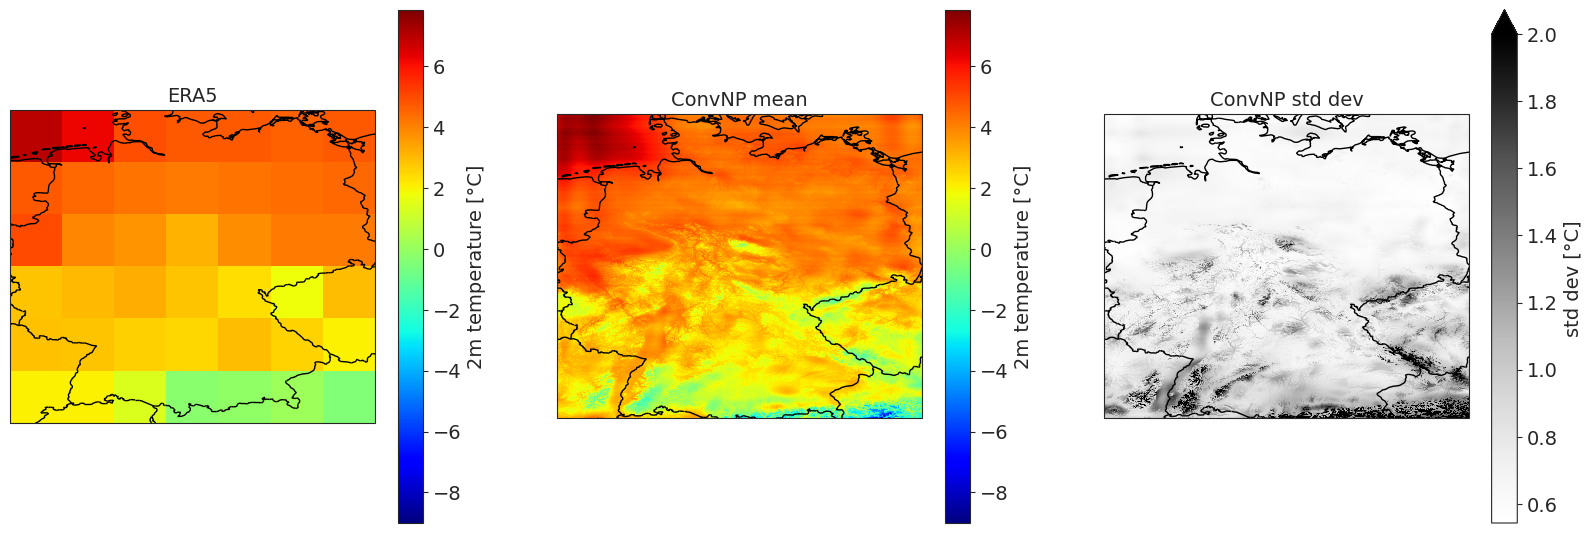

In [93]:
fig, axes = gen_test_fig(
    era5_raw_ds.sel(time=test_task['time'], lat=slice(mean_ds["lat"].min(), mean_ds["lat"].max()), lon=slice(mean_ds["lon"].min(), mean_ds["lon"].max())),
    mean_ds["T2M"],
    std_ds["T2M"],
    add_colorbar=True,
    var_cbar_label="2m temperature [°C]",
    std_cbar_label="std dev [°C]",
    std_clim=(None, 2),
    figsize=(20, 20/3)
)
fig.savefig("downscale.png", bbox_inches="tight")

### Predict at specific location to time series

In [49]:
X_t = np.array([[50.5, 9.25]]).T
dates = pd.date_range("2019-09-01", "2019-10-31")

In [50]:
station_raw_df

T2M
time       lat     lon               
2005-05-02 47.3981 10.2757  15.862500
           47.4210 10.9848   3.637500
           47.4830 11.0621  17.787500
           47.5627 7.7936   19.287500
           47.5776 9.7404   19.187500
...                               ...
2023-07-18 54.6410 10.0238  16.612500
           54.6791 13.4344  17.712500
           54.7903 8.9514   16.500000
           54.8273 9.5058   16.183333
           55.0110 8.4125   16.687500

[3301201 rows x 1 columns]

In [51]:
# Get all locations of stations from station_raw_df
locs = set(zip(station_raw_df.reset_index()["lat"], station_raw_df.reset_index()["lon"]))
locs

{(47.3981, 10.2757),
 (47.3984, 10.2759),
 (47.421, 10.9848),
 (47.4779, 11.2653),
 (47.483, 11.0621),
 (47.559, 7.7721),
 (47.5627, 7.7936),
 (47.5776, 9.7404),
 (47.6187, 12.1665),
 (47.6362, 10.3892),
 (47.6652, 11.0805),
 (47.6754, 12.4698),
 (47.6772, 9.1901),
 (47.6774, 9.19),
 (47.678, 8.3799),
 (47.6783, 8.3801),
 (47.6845, 9.4409),
 (47.6952, 9.1307),
 (47.7004, 8.1057),
 (47.7035, 12.0119),
 (47.7233, 10.3348),
 (47.7235, 10.3352),
 (47.7724, 12.9073),
 (47.7738, 8.8219),
 (47.7955, 10.0325),
 (47.8009, 11.0108),
 (47.8062, 9.6206),
 (47.8064, 7.6387),
 (47.818, 9.797),
 (47.8208, 8.186),
 (47.8333, 10.8667),
 (47.8342, 10.8667),
 (47.835, 12.6548),
 (47.8516, 8.7673),
 (47.8597, 8.2308),
 (47.8652, 10.6007),
 (47.8748, 8.0038),
 (47.8753, 12.128),
 (47.8761, 10.5849),
 (47.8774, 11.3643),
 (47.8823, 11.6961),
 (47.8827, 11.1576),
 (47.8843, 12.5404),
 (47.8991, 8.146),
 (47.9242, 8.6474),
 (47.9345, 9.2869),
 (47.9625, 7.9983),
 (47.9821, 10.1384),
 (48.0007, 7.845),
 (48.00

In [60]:
# Find closest station to desired target location
X_station_closest = min(locs, key=lambda loc: np.linalg.norm(np.array(loc) - X_t.T))
X_t = np.array(X_station_closest).reshape(2, 1)
X_t

array([[50.5084],
       [ 9.2246]])

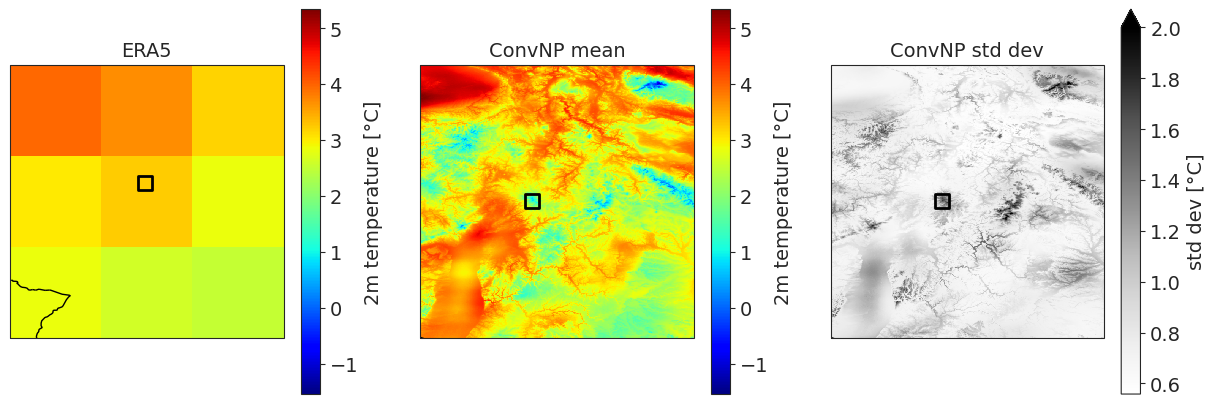

In [91]:
# As above but zooming in
fig, axes = gen_test_fig(
    era5_raw_ds.sel(time=test_task['time'], lat=slice(49, 52), lon=slice(8, 11)),
    mean_ds["T2M"].sel(lat=slice(52, 49), lon=slice(8, 11)),
    std_ds["T2M"].sel(lat=slice(52, 49), lon=slice(8, 11)),
    add_colorbar=True,
    # var_clim=(10, -5),
    var_cbar_label="2m temperature [°C]",
    std_cbar_label="std dev [°C]",
    std_clim=(None, 2),
)
# Plot X_t
for ax in axes:
    ax.scatter(X_t[1], X_t[0], marker="s", color="black", transform=crs, s=10**2, facecolors='none', linewidth=2)
fig.savefig("downscale_zoom.png", bbox_inches="tight")

In [62]:
# Get station target data
station_closest_df = station_raw_df.reset_index().set_index(["lat", "lon"]).loc[X_station_closest].set_index("time").loc[dates]
station_closest_df

,T2M
2019-09-01,14.870833
2019-09-02,12.062500
2019-09-03,13.983333
2019-09-04,14.879167
2019-09-05,10.595833
...,...
2019-10-27,6.754167
2019-10-28,3.441667
2019-10-29,2.958333
2019-10-30,0.995833


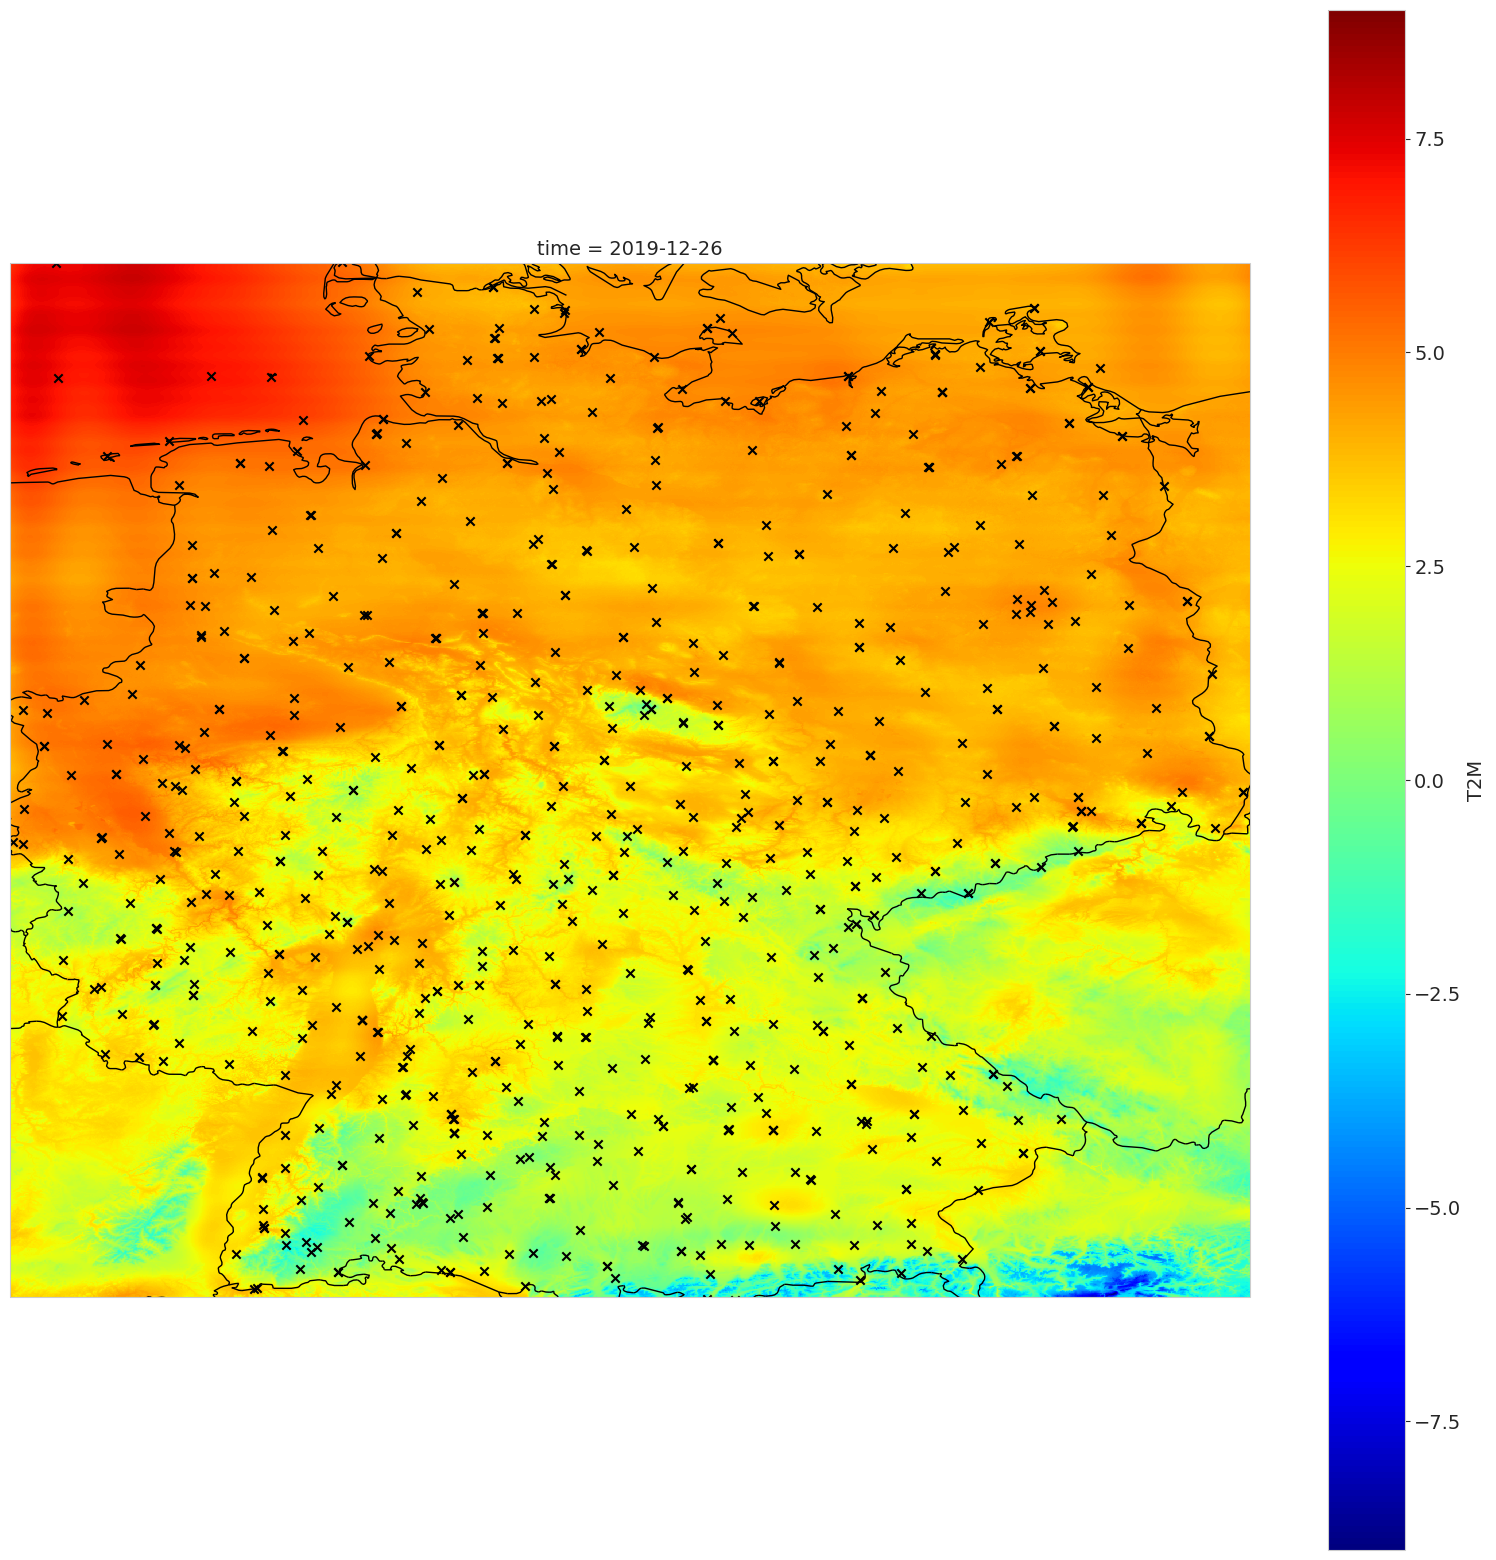

In [63]:
# Plot location of X_t on map using cartopy
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs), figsize=(20, 20))
mean_ds['T2M'].plot(ax=ax, cmap="jet")
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.scatter(X_t[1], X_t[0], transform=crs, color="red", marker="x")
# Plot station locations
ax.scatter([loc[1] for loc in locs], [loc[0] for loc in locs], transform=crs, color="black", marker="x")
ax.set_extent([6, 15, 47.5, 55])

In [64]:
test_tasks = task_loader(dates, "all")
mean_df, std_df = model.predict(test_tasks, X_t=X_t, progress_bar=True)

100%|██████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 47.79it/s]


In [65]:
mean_df = mean_df.reset_index()[["time", "T2M"]].set_index("time")
mean_df

,T2M
time,
2019-09-01,15.519115
2019-09-02,11.800596
2019-09-03,12.690853
2019-09-04,14.626774
2019-09-05,11.821367
...,...
2019-10-27,6.600003
2019-10-28,2.102712
2019-10-29,2.621078


In [66]:
std_df = std_df.reset_index()[["time", "T2M"]].set_index("time")
std_df

,T2M
time,
2019-09-01,1.540367
2019-09-02,1.529726
2019-09-03,1.505895
2019-09-04,1.535479
2019-09-05,1.506772
...,...
2019-10-27,1.653311
2019-10-28,1.751347
2019-10-29,1.588691


In [67]:
# Interpolate ERA5 at these locations
era5_raw_df = era5_raw_ds.sel(lat=47.5, lon=8, method="nearest").to_dataframe()
era5_raw_df = era5_raw_df.loc[dates]
era5_raw_df

,realization,lat,lon,t2m
2019-09-01,0,47.75,8.0,19.515203
2019-09-02,0,47.75,8.0,15.611904
2019-09-03,0,47.75,8.0,14.999718
2019-09-04,0,47.75,8.0,16.620045
2019-09-05,0,47.75,8.0,13.611761
...,...,...,...,...
2019-10-27,0,47.75,8.0,13.050340
2019-10-28,0,47.75,8.0,9.646043
2019-10-29,0,47.75,8.0,7.113743
2019-10-30,0,47.75,8.0,6.393884


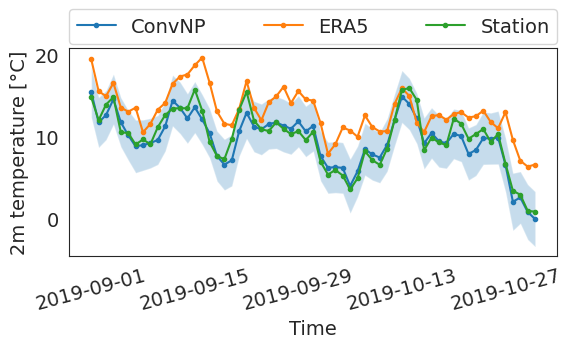

In [86]:
# Plot
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(7*.9, 3*.9))
convnp_mean = mean_df["T2M"].values.astype('float')
ax.plot(convnp_mean, label="ConvNP", marker="o", markersize=3)
stddev = std_df["T2M"].values.astype('float')
# Make 95% confidence interval
ax.fill_between(range(len(convnp_mean)), convnp_mean - 2 * stddev, convnp_mean + 2 * stddev, alpha=0.25)#, label="ConvNP 95% CI")
era5_vals = era5_raw_df["t2m"].values.astype('float')
ax.plot(era5_vals, label="ERA5", marker="o", markersize=3)
# Plot true station data
ax.plot(station_closest_df["T2M"].values.astype('float'), label="Station", marker="o", markersize=3)
# Add legend
ax.legend(loc="lower left", bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=3, mode="expand", borderaxespad=0)
ax.set_xlabel("Time")
ax.set_ylabel("2m temperature [°C]")
ax.set_xticks(range(len(era5_raw_df))[::14])
ax.set_xticklabels(era5_raw_df.index[::14].strftime("%Y-%m-%d"), rotation=15)
plt.savefig("convnp_timeseries.png", bbox_inches="tight")